# EX14 Transformer Chatbot  
## Objective  
1. 한국어 전처리를 통해 학습 데이터셋을 구축하였다.  
- 공백과 특수문자 처리, 토크나이징, 병렬데이터 구축의 과정이 적절히 진행되었다.  
2. 트랜스포머 모델을 구현하여 한국어 챗봇 모델 학습을 정상적으로 진행하였다.  
- 구현한 트랜스포머 모델이 한국어 병렬 데이터 학습 시 안정적으로 수렴하였다.  
3. 한국어 입력문장에 대해 한국어로 답변하는 함수를 구현하였다.  
- 한국어 입력문장에 맥락에 맞는 한국어로 답변을 리턴하였다.  

In [3]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Step 1.  데이터 수집하기
한국어 챗봇 데이터는 송영숙님이 공개한 챗봇 데이터를 사용합니다  
https://github.com/songys/Chatbot_data   
일상다반사 0, 이별(부정) 1, 사랑(긍정) 2로 레이블링  

In [4]:
file_path=os.getenv('HOME') + '/aiffel/transformer_chatbot/data/ChatbotData .csv'
original_data = pd.read_csv(file_path)
original_data.head()

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


In [13]:
len(original_data)

11823

총 11823개의 한국어 챗봇 데이터를 불러왔습니다

### Step 2. 데이터 전처리하기  
지난 요약 프로젝트에서 사용한 방법입니다  
- 중복 제거  
- 결측치 제거  
- 텍스트 정규화  
- 특수문자 제거  
- 다시한번 결측치 제거  

In [9]:
#결측치확인
original_data.isna().sum()

Q        0
A        0
label    0
dtype: int64

In [11]:
#중복제거
original_data = original_data.drop_duplicates()
original_data.shape

(11823, 3)

결측치와 중복은 없었습니다  
정규화를 시켜줍니다  
- 문장에서 단어와 구두점 사이에 공백을 추가  
- 알파벳(한글)과 ! ? , . 이 4개의 구두점을 제외하고 다른 특수문자는 모두 제거

In [14]:
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()


    # (한글, a-z, A-Z, ".", "?", "!", ",")를 제외한 모든 문자를 공백인 ' '로 대체합니다.
    sentence = re.sub(r"^[ㄱ-ㅎ|가-힣|a-z|A-Z|0-9|]+$", " ", sentence)

    # 단어와 구두점(punctuation) 사이의 거리를 만듭니다.
    # 예를 들어서 "I am a student." => "I am a student ."와 같이
    # student와 온점 사이에 거리를 만듭니다.
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = sentence.strip()
    return sentence

In [27]:
data = original_data.copy()
data.Q = data.Q.apply(preprocess_sentence)
data.A = data.A.apply(preprocess_sentence)
data.head(30)

,Q,A,label
0,12시 땡 !,하루가 또 가네요 .,0
1,1지망 학교 떨어졌어,위로해 드립니다 .,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠 .,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠 .,0
4,ppl 심하네,눈살이 찌푸려지죠 .,0
5,sd카드 망가졌어,다시 새로 사는 게 마음 편해요 .,0
6,sd카드 안돼,다시 새로 사는 게 마음 편해요 .,0
7,sns 맞팔 왜 안하지ㅠㅠ,잘 모르고 있을 수도 있어요 .,0
8,sns 시간낭비인 거 아는데 매일 하는 중,시간을 정하고 해보세요 .,0
9,sns 시간낭비인데 자꾸 보게됨,시간을 정하고 해보세요 .,0


요구사항이 잘 맞춰진 것 같습니다  
다시한번 결측치를 확인한 후, 있다면 제거해줍니다

In [28]:
#결측치확인
data.isna().sum()

Q        0
A        0
label    0
dtype: int64

In [63]:
# 이후 단계를 준비해줍니다
questions = data.Q.values.copy()
answers = data.A.values.copy()

questions

array(['12시 땡 !', '1지망 학교 떨어졌어', '3박4일 놀러가고 싶다', ..., '흑기사 해주는 짝남 .',
       '힘든 연애 좋은 연애라는게 무슨 차이일까 ?', '힘들어서 결혼할까봐'], dtype=object)

### Step 3. SubwordTextEncoder 사용하기  
한국어 데이터는 형태소 분석기를 사용하여 토크나이징을 해야 한다고 많은 분이 알고 있습니다  
하지만 여기서는 형태소 분석기가 아닌 실습에서 사용했던 내부 단어 토크나이저인 SubwordTextEncoder를 그대로 사용해봅니다  
- TensorFlow Datasets SubwordTextEncoder 를 토크나이저로 사용하기
- 단어보다 더 작은 단위인 Subword를 기준으로 토크나이징하고,  각 토큰을 고유한 정수로 인코딩하기
- 각 문장을 토큰화하고 각 문장의 시작과 끝을 나타내는 START_TOKEN 및 END_TOKEN을 추가하기
- 최대 길이 MAX_LENGTH를 넘는 문장들은 필터링 / MAX_LENGTH보다 길이가 짧은 문장들은 범위에 맞도록 패딩

단어장을 생성합니다  

In [64]:
import tensorflow_datasets as tfds

# 질문과 답변 데이터셋에 대해서 Vocabulary 생성

tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=2**13)

target_vocab_size = 2^13이 적절할까요?  
퍼포먼스를 봐서, EX12에 했던 단어 갯수를 세는 함수를 사용해서 탐색해봐도 괜찮을 거 같습니다

In [65]:
# 디코더의 문장 생성 과정에서 사용할 '시작 토큰'과 '종료 토큰'
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]
# 단어장의 크기
VOCAB_SIZE = tokenizer.vocab_size + 2
# 샘플의 최대 허용 길이 또는 패딩 후의 최종 길이
MAX_LENGTH = 40
VOCAB_SIZE

8269

8269의 크기를 가진 단어장이 생성되었습니다  
정수 인코딩을 진행합니다  
동시에 MAX_LENGTH를 넘는 샘플은 제거 이후, 패딩을 진행합니다

In [66]:
# 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩
def tokenize_and_filter(inputs, outputs):
    tokenized_inputs, tokenized_outputs = [], []
  
    for (sentence1, sentence2) in zip(inputs, outputs):
    # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
        sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
        sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

        # 최대 길이 40 이하인 경우에만 데이터셋으로 허용
        if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
            tokenized_inputs.append(sentence1)
            tokenized_outputs.append(sentence2)
  
  # 최대 길이 40으로 모든 데이터셋을 패딩
    tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
    tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
  
    return tokenized_inputs, tokenized_outputs

In [70]:

print('필터링 전의 질문 샘플 개수: {}'.format(len(questions)))
print('필터링 전의 답변 샘플 개수: {}'.format(len(answers)))

questions, answers = tokenize_and_filter(questions, answers)
print('단어장의 크기 :',(VOCAB_SIZE))

print('필터링 후의 질문 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers)))


필터링 전의 질문 샘플 개수: 11823
필터링 전의 답변 샘플 개수: 11823
단어장의 크기 : 8269
필터링 후의 질문 샘플 개수: 11823
필터링 후의 답변 샘플 개수: 11823


샘플갯수의 변화는 없었습니다  
패딩이 많을수록 추론 효과가 적다고 들었어서, 이후 추론결과가 좋지 않다면 개선할 수 있는 부분으로 기록해두겠습니다 

 교사 강요(Teacher Forcing)를 사용하는 입력 파이프라인을 만듭니다  
answers[:, :-1]를 디코더의 입력값, answers[:, 1:]를 디코더의 레이블로 사용합니다.  

In [72]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

In [73]:

# 디코더는 이전의 target을 다음의 input으로 사용합니다.
# 이에 따라 outputs에서는 START_TOKEN을 제거하겠습니다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

### Step 4. 모델 구성하기

트랜스포머 함수를 정의합니다  
진행에 필요한 함수들 또한 함께 정의합니다  
  
먼저 패딩 마스킹 함수를 정의합니다

In [82]:
def create_padding_mask(x):
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)
    # (batch_size, 1, 1, sequence length)
    return mask[:, tf.newaxis, tf.newaxis, :]

룩 어헤드 마스킹 함수도 정의합니다

In [94]:
def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    padding_mask = create_padding_mask(x)
    return tf.maximum(look_ahead_mask, padding_mask)

스케일드 닷 프로덕트 어텐션

In [175]:
# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
    # 어텐션 가중치는 Q와 K의 닷 프로덕트
    matmul_qk = tf.matmul(query, key, transpose_b=True)

    # 가중치를 정규화
    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    logits = matmul_qk / tf.math.sqrt(depth)

    # 패딩에 마스크 추가
    if mask is not None:
        logits += (mask * -1e9)

    # softmax적용
    attention_weights = tf.nn.softmax(logits, axis=-1)

    # 최종 어텐션은 가중치와 V의 닷 프로덕트
    output = tf.matmul(attention_weights, value)
    return output


멀티 헤드 어텐션

In [135]:
class MultiHeadAttention(tf.keras.layers.Layer):
    
    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__(name=name)
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)

        self.dense = tf.keras.layers.Dense(units=d_model)

    def split_heads(self, inputs, batch_size):
        inputs = tf.reshape(
            inputs, shape=(batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(inputs, perm=[0, 2, 1, 3])

    def call(self, inputs):
        query, key, value, mask = inputs['query'], inputs['key'], inputs[
            'value'], inputs['mask']
        batch_size = tf.shape(query)[0]

        # Q, K, V에 각각 Dense를 적용합니다
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        # 병렬 연산을 위한 머리를 여러 개 만듭니다
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        # 스케일드 닷 프로덕트 어텐션 함수
        scaled_attention = scaled_dot_product_attention(query, key, value, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

        # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
        concat_attention = tf.reshape(scaled_attention,
                                      (batch_size, -1, self.d_model))

        # 최종 결과에도 Dense를 한 번 더 적용합니다
        outputs = self.dense(concat_attention)

        return outputs

포지셔널 인코딩 함수입니다

In [136]:
class PositionalEncoding(tf.keras.layers.Layer):

    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles
 
    def positional_encoding(self, position, d_model):
    # 각도 배열 생성
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model=d_model)

        # 배열의 짝수 인덱스에는 sin 함수 적용
        sines = tf.math.sin(angle_rads[:, 0::2])
        # 배열의 홀수 인덱스에는 cosine 함수 적용
        cosines = tf.math.cos(angle_rads[:, 1::2])

        # sin과 cosine이 교차되도록 재배열
        pos_encoding = tf.stack([sines, cosines], axis=0)
        pos_encoding = tf.transpose(pos_encoding,[1, 2, 0]) 
        pos_encoding = tf.reshape(pos_encoding, [position, d_model])

        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

인코더를 정의합니다

In [137]:
# 인코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 두 개의 서브 레이어가 존재합니다.
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

    # 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
    attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })

    # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
    attention = tf.keras.layers.Dropout(rate=dropout)(attention)
    attention = tf.keras.layers.LayerNormalization(
    epsilon=1e-6)(inputs + attention)

    #두 번째 서브 레이어 : 2개의 완전연결층
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    #완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

    return tf.keras.Model(inputs=[inputs, padding_mask], outputs=outputs, name=name)


In [138]:
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")

    # 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # num_layers만큼 쌓아올린 인코더의 층.
    for i in range(num_layers):
        outputs = encoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name="encoder_layer_{}".format(i),
        )([outputs, padding_mask])

    return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

디코더를 정의합니다

In [139]:
# 디코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 세 개의 서브 레이어가 존재합니다.
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
    look_ahead_mask = tf.keras.Input(
        shape=(1, None, None), name="look_ahead_mask")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
    attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
      })

    # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

    # 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
    attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1,
          'key': enc_outputs,
          'value': enc_outputs,
          'mask': padding_mask
      })

    # 마스크드 멀티 헤드 어텐션의 결과는
    # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
    attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)

    # 세 번째 서브 레이어 : 2개의 완전연결층
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

    return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)


In [140]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
    inputs = tf.keras.Input(shape=(None,), name='inputs')
    enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
    look_ahead_mask = tf.keras.Input(
        shape=(1, None, None), name='look_ahead_mask')

    # 패딩 마스크
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
  
    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    # Dropout이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    for i in range(num_layers):
      outputs = decoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

    return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)


대망의 트랜스포머 함수입니다

In [141]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

    # 인코더에서 패딩을 위한 마스크
    enc_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None),
        name='enc_padding_mask')(inputs)

    # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
    # 내부적으로 패딩 마스크도 포함되어져 있습니다.
    look_ahead_mask = tf.keras.layers.Lambda(
        create_look_ahead_mask,
        output_shape=(1, None, None),
        name='look_ahead_mask')(dec_inputs)

    # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
    # 디코더에서 패딩을 위한 마스크
    dec_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None),
        name='dec_padding_mask')(inputs)

    # 인코더
    enc_outputs = encoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
    )(inputs=[inputs, enc_padding_mask])

    # 디코더
    dec_outputs = decoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
    )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

    # 완전연결층
    outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

    return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

손실함수를 정의합니다  
cross entropy를 쓰는군요  
레이블인 시퀀스에 패딩이 되어 있으므로, loss를 계산할 때 패딩 마스크를 적용해야 합니다  

In [142]:
def loss_function(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  
    loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')(y_true, y_pred)

    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    loss = tf.multiply(loss, mask)

    return tf.reduce_mean(loss)


Model의 Learning rate를 스케쥴링 할 수 있는 커스텀 스케쥴러를 정의합니다  

In [143]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

드디어 모델을 정의합니다  


In [144]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율


In [145]:
model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 256)    3171072     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

#### 학습

컴파일~

In [148]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

In [149]:
EPOCHS = 50
history = model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/50
185/185 [==============================] - 25s 54ms/step - loss: 1.4576 - accuracy: 0.0188
Epoch 2/50
185/185 [==============================] - 10s 54ms/step - loss: 1.1826 - accuracy: 0.0489
Epoch 3/50
185/185 [==============================] - 10s 55ms/step - loss: 1.0064 - accuracy: 0.0508
Epoch 4/50
185/185 [==============================] - 10s 55ms/step - loss: 0.9288 - accuracy: 0.0544
Epoch 5/50
185/185 [==============================] - 10s 55ms/step - loss: 0.8705 - accuracy: 0.0577
Epoch 6/50
185/185 [==============================] - 10s 55ms/step - loss: 0.8109 - accuracy: 0.0620
Epoch 7/50
185/185 [==============================] - 10s 55ms/step - loss: 0.7451 - accuracy: 0.0678
Epoch 8/50
185/185 [==============================] - 10s 54ms/step - loss: 0.6732 - accuracy: 0.0756
Epoch 9/50
185/185 [==============================] - 10s 54ms/step - loss: 0.5950 - accuracy: 0.0842
Epoch 10/50
185/185 [==============================] - 10s 54ms/step - loss: 0.513

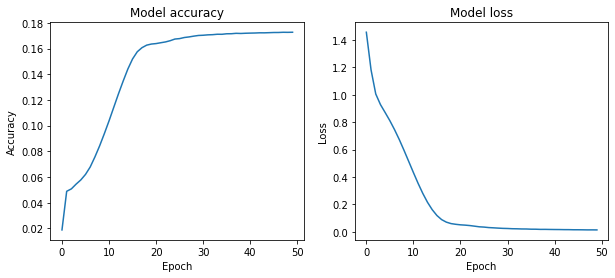

In [159]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (10, 4))


plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()


학습은 30 에폭 이후 accuracy 와 loss가 수렴했습니다

### Step 5. 모델 평가하기  
모델이 잘 학습되었는지 테스트해봅니다  
추론 함수를 정의합니다  

In [161]:
def decoder_inference(sentence):
    sentence = preprocess_sentence(sentence)
  
    # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
    # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
    sentence = tf.expand_dims(
        START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

    # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
    # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
    output_sequence = tf.expand_dims(START_TOKEN, 0)

    # 디코더의 인퍼런스 단계
    for i in range(MAX_LENGTH):
    # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
        predictions = model(inputs=[sentence, output_sequence], training=False)
        predictions = predictions[:, -1:, :]

        # 현재 예측한 단어의 정수
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
        if tf.equal(predicted_id, END_TOKEN[0]):
            break

        # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
        # 이 output_sequence는 다시 디코더의 입력이 됩니다.
        output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

    return tf.squeeze(output_sequence, axis=0)


In [162]:
def sentence_generation(sentence):
    # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
    prediction = decoder_inference(sentence)

    # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
    predicted_sentence = tokenizer.decode(
        [i for i in prediction if i < tokenizer.vocab_size])

    print('입력 : {}'.format(sentence))
    print('출력 : {}'.format(predicted_sentence))

    return predicted_sentence

In [164]:
sentence_generation("멍멍")

입력 : 멍멍
출력 : 많이 힘든가봅니다 .


'많이 힘든가봅니다 .'

In [165]:
sentence_generation("자고싶다")

입력 : 자고싶다
출력 : 많이 힘든가봅니다 .


'많이 힘든가봅니다 .'

In [166]:
sentence_generation("굿모닝")

입력 : 굿모닝
출력 : 많이 힘든가봅니다 .


'많이 힘든가봅니다 .'

에러인가 싶었습니다 ㄷㄷㄷ

In [167]:
sentence_generation("한잔할래?")

입력 : 한잔할래?
출력 : 분위기 있네요 .


'분위기 있네요 .'

In [168]:
sentence_generation("오늘 날씨가 좋아요")

입력 : 오늘 날씨가 좋아요
출력 : 집밖에 나가기가 힘들것 같아요 .


'집밖에 나가기가 힘들것 같아요 .'

In [169]:
sentence_generation("사랑해요")

입력 : 사랑해요
출력 : 많이 힘든가봅니다 .


'많이 힘든가봅니다 .'

왜 이러는걸까요

In [170]:
sentence_generation("나한테 왜 이래?")

입력 : 나한테 왜 이래?
출력 : 존재 자체로 큰 힘이 되어주고 있나봅니다 .


'존재 자체로 큰 힘이 되어주고 있나봅니다 .'

In [171]:
sentence_generation("보고싶다")

입력 : 보고싶다
출력 : 많이 힘든가봅니다 .


'많이 힘든가봅니다 .'

In [173]:
sentence_generation("많이 힘들다")

입력 : 많이 힘들다
출력 : 그 과정을 통해 성장할 수 있을 거예요 .


'그 과정을 통해 성장할 수 있을 거예요 .'

In [174]:
sentence_generation("아직 잘 모르겠어요")

입력 : 아직 잘 모르겠어요
출력 : 사랑과 결혼을 동일시하지 않아도 돼요 . 시간을 가지고 생각해보세요 .


'사랑과 결혼을 동일시하지 않아도 돼요 . 시간을 가지고 생각해보세요 .'

가끔은 엉뚱하지만 대체로 듣고싶은 말, 혹은 문맥에 맞지만 놀라운 말을 본 것 같습니다

# 회고 
결과물은 굉장히 재미있었습니다  
### 인상깊은 점  
데이터셋이 적기 때문에 매우 엉성한 결과를 기대했는데, 의외로 어느정도 컨텍스트를 확인할 수 있었습니다  
### 아쉬운점  
공부를 하면서 작성을 했지만, 결국 함수들을 모두 새롭게 짜보지는 못하고, 가져다 쓰게 되었습니다 ..  
NLP쪽도 잘하고 싶었는데, 결국 마지막 노드가 될 이번 EX도 다양한 실험을 해보며 익숙해지지 못해서 더 아쉬움이 큰 것 같습니다  
### 기대되는 점
해당 데이터셋은 아래 페이지에 명시되어 있듯이, '이별' 상황에서 듣는 따뜻한 문장들에서 데이터를 모아 만들었습니다  
https://github.com/songys/Chatbot_data  
실제로 구현된 챗봇과 대화하며, 왠지 이녀석은 따뜻하군~ 이라고 생각했습니다  
결국 데이터셋을 한정하면, '성격' '감성' 을 가진(듯한) 챗봇을 구현할 수 있을거라 기대됩니다  
  
참고 : https://wikidocs.net/89786